## Training code

This program saves the last 3 generations of models to Google Drive. Since 1 generation of models is >1GB, you should have at least 3GB of free space in Google Drive. If you do not have such free space, it is recommended to create another Google Account.

Training requires >10GB VRAM. (T4 should be enough) Inference does not require such a lot of VRAM.

## Installation

In [ ]:
#@title Check GPU
!nvidia-smi

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Install dependencies
#@markdown pip may fail to resolve dependencies and raise ERROR, but it can be ignored.
!python -m pip install -U pip wheel
%pip install -U ipython

#@markdown Branch (for development)
BRANCH = "none" #@param {"type": "string"}
if BRANCH == "none":
    %pip install -U so-vits-svc-fork
else:
    %pip install -U git+https://github.com/34j/so-vits-svc-fork.git@{BRANCH}

## Data
This time we used data from the game, the format is mp3, there are 82 voice, each voice length is different, from the shortest 5s to the longest 25s, and there may be multiple pauses in a voice. So we're going to use software to split the pauses into 205 voice segments, around 5 seconds each. The short speech ensures that the model does not take too long to learn one speech. Then we will reduce the noise of the speech and remove the background sound effects, so that the model can better learn the characteristics of the voice.
The detailed method and introduction are in the presentation jupyter notebook.

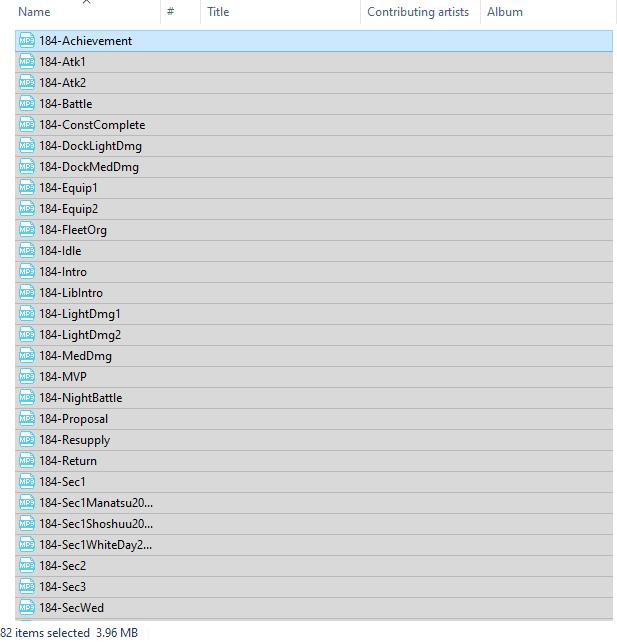

In [3]:
from PIL import Image
Image.open('number_of_raw_audio.jpg')

The average length for each mp3 is 14.5s


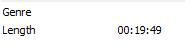

In [10]:
print(f'The average length for each mp3 is {(19*60+49)/82}s')
Image.open('length.jpg')

The average length for each mp3 is 5.8s


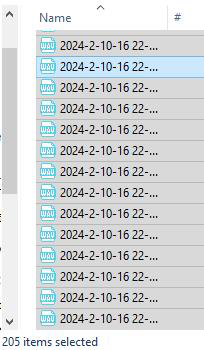

In [11]:
print(f'The average length for each mp3 is {(19*60+49)/205}s')
Image.open('after.jpg')

Here will show you how is the sonogram look like after and before the denoising

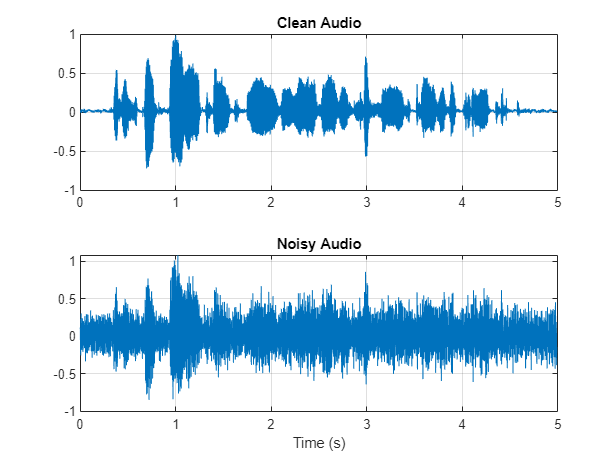

In [5]:
Image.open('noisy_clean.png')

## Training

In [ ]:
#@title Make dataset directory
!mkdir -p "dataset_raw"

In [ ]:
#!rm -r "dataset_raw"
#!rm -r "dataset/44k"

In [ ]:
#@title Copy your dataset
#@markdown **We assume that your dataset is in your Google Drive's `so-vits-svc-fork/dataset/(speaker_name)` directory.**
DATASET_NAME = "kiritan" #@param {type: "string"}
!cp -R /content/drive/MyDrive/so-vits-svc-fork/dataset/{DATASET_NAME}/ -t "dataset_raw/"

In [ ]:
#@title Download dataset (Tsukuyomi-chan JVS)
#@markdown You can download this dataset if you don't have your own dataset.
#@markdown Make sure you agree to the license when using this dataset.
#@markdown https://tyc.rei-yumesaki.net/material/corpus/#toc6
# !wget https://tyc.rei-yumesaki.net/files/sozai-tyc-corpus1.zip
# !unzip sozai-tyc-corpus1.zip
# !mv "/content/つくよみちゃんコーパス Vol.1 声優統計コーパス（JVSコーパス準拠）/おまけ：WAV（+12dB増幅＆高音域削減）/WAV（+12dB増幅＆高音域削減）" "dataset_raw/tsukuyomi"

In [ ]:
#@title Automatic preprocessing
!svc pre-resample

In [ ]:
!svc pre-config

In [ ]:
#@title Export configs file
#@markdown This assumes that you want to save the **config.json** on the default location. There will be also a backup file created in case the action is done accidentally.!cp configs/44k/config.json configs/44k/config.bkp.json!cp drive/MyDrive/so-vits-svc-fork/config.json configs/44k

In [ ]:
#@title Import configs file (Optional Step, NOT REQUIRED)
#@markdown This assumes that you are saving the **config.json** on the default location. There will be also a backup file created in case the action is done accidentally.!cp drive/MyDrive/so-vits-svc-fork/config.json drive/MyDrive/so-vits-svc-fork/config.bkp.json!cp configs/44k/config.json drive/MyDrive/so-vits-svc-fork

In [ ]:
F0_METHOD = "dio" #@param ["crepe", "crepe-tiny", "parselmouth", "dio", "harvest"]
!svc pre-hubert -fm {F0_METHOD}

In [ ]:
#@title Train
%load_ext tensorboard
%tensorboard --logdir drive/MyDrive/so-vits-svc-fork/logs/44k
!svc train --model-path drive/MyDrive/so-vits-svc-fork/logs/44k

## Training Cluster model

In [ ]:
!svc train-cluster --output-path drive/MyDrive/so-vits-svc-fork/logs/44k/kmeans.pt

## Inference

In [ ]:
#@title Get the author's voice as a source
import random
NAME = str(random.randint(1, 49))
TYPE = "fsd50k" #@param ["", "digit", "dog", "fsd50k"]
CUSTOM_FILEPATH = "" #@param {type: "string"}
if CUSTOM_FILEPATH != "":
    NAME = CUSTOM_FILEPATH
else:
    # it is extremely difficult to find a voice that can download from the internet directly
    if TYPE == "dog":
        !wget -N f"https://huggingface.co/datasets/437aewuh/dog-dataset/resolve/main/dogs/dogs_{NAME:.0000}.wav" -O {NAME}.wav
    elif TYPE == "digit":
        # george, jackson, lucas, nicolas, ...
        !wget -N f"https://github.com/Jakobovski/free-spoken-digit-dataset/raw/master/recordings/0_george_{NAME}.wav" -O {NAME}.wav
    elif TYPE == "fsd50k":
        !wget -N f"https://huggingface.co/datasets/Fhrozen/FSD50k/blob/main/clips/dev/{10000+int(NAME)}.wav" -O {NAME}.wav
    else:
        !wget -N f"https://zunko.jp/sozai/utau/voice_{"kiritan" if NAME < 25 else "itako"}{NAME % 5 + 1}.wav" -O {NAME}.wav
from IPython.display import Audio, display
display(Audio(f"{NAME}.wav"))

In [ ]:
#@title Use trained model
#@markdown **Put your .wav file in `so-vits-svc-fork/audio` directory**
from IPython.display import Audio, display
!svc infer drive/MyDrive/so-vits-svc-fork/audio/{NAME}.wav -m drive/MyDrive/so-vits-svc-fork/logs/44k/ -c drive/MyDrive/so-vits-svc-fork/logs/44k/config.json
display(Audio(f"drive/MyDrive/so-vits-svc-fork/audio/{NAME}.out.wav", autoplay=True))

In [ ]:
##@title Use trained model (with cluster)
!svc infer {NAME}.wav -s speaker -r 0.1 -m drive/MyDrive/so-vits-svc-fork/logs/44k/ -c drive/MyDrive/so-vits-svc-fork/logs/44k/config.json -k drive/MyDrive/so-vits-svc-fork/logs/44k/kmeans.pt
display(Audio(f"{NAME}.out.wav", autoplay=True))

### Pretrained models

In [ ]:
#@title https://huggingface.co/TachibanaKimika/so-vits-svc-4.0-models/tree/main
!wget -N "https://huggingface.co/TachibanaKimika/so-vits-svc-4.0-models/resolve/main/riri/G_riri_220.pth"
!wget -N "https://huggingface.co/TachibanaKimika/so-vits-svc-4.0-models/resolve/main/riri/config.json"

In [ ]:
!svc infer {NAME}.wav -c config.json -m G_riri_220.pth
display(Audio(f"{NAME}.out.wav", autoplay=True))

In [ ]:
#@title https://huggingface.co/therealvul/so-vits-svc-4.0/tree/main
!wget -N "https://huggingface.co/therealvul/so-vits-svc-4.0/resolve/main/Pinkie%20(speaking%20sep)/G_166400.pth"
!wget -N "https://huggingface.co/therealvul/so-vits-svc-4.0/resolve/main/Pinkie%20(speaking%20sep)/config.json"

In [ ]:
!svc infer {NAME}.wav --speaker "Pinkie {neutral}" -c config.json -m G_166400.pth
display(Audio(f"{NAME}.out.wav", autoplay=True))